<a href="https://colab.research.google.com/github/PCBZ/CS6180-Course/blob/main/HW2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2-Q2: [Sequential Modelling] Building a Word-Level LSTM Language Model
## Objective
Implement and train an LSTM-based language model that predicts the next word in a sequence using a specialized dataset (e.g., book titles).
### Learning Goals:
- Understand data preprocessing for NLP tasks.
- Build, train, and evaluate a sequence model using LSTM.
- Explore creativity in sentence generation and architecture design.

## Part 1: Data Loading and Initial Exploration

In this section, we load and explore the dataset containing book titles. The key steps performed include:

1. **Loading the Dataset**: The dataset is loaded directly from a URL into a pandas DataFrame.
2. **Basic Information Display**: Basic information about the dataset, including column names and sample data, is displayed.
3. **Title Preprocessing**: Titles are preprocessed by converting them to lowercase and removing non-alphabetic characters.
4. **Title Length Calculation**: The length of each title (in terms of the number of words) is calculated, and basic statistics are displayed.
5. **Visualization**: The distribution of title lengths is plotted using a histogram and box plot, and a word cloud is generated to visualize the most common words in the book titles.


### More on GoodBooks10K Dataset

The **GoodBooks10K** dataset is a comprehensive collection of user ratings, reviews, and metadata for 10,000 books. It is commonly used for recommender systems research and analysis. The dataset includes:

- **Books metadata**: Titles, authors, genres, and publication information.
- **User interactions**: Ratings (1-5 scale) and textual reviews.
- **Additional features**: Tags and user-generated lists.

This dataset provides a rich resource for exploring collaborative filtering, natural language processing, and book-related data analysis.

For more information and to access the dataset, visit the [Kaggle page](https://www.kaggle.com/datasets/zygmunt/goodbooks-10k/).

For insights into advanced recommendation system research, refer to NVIDIA's paper on **Deep Learning-Based Recommender Systems** ([arXiv:1911.12391](https://arxiv.org/pdf/1911.12391)).

Dataset loaded successfully!
Columns: Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

Sample Data:
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors 

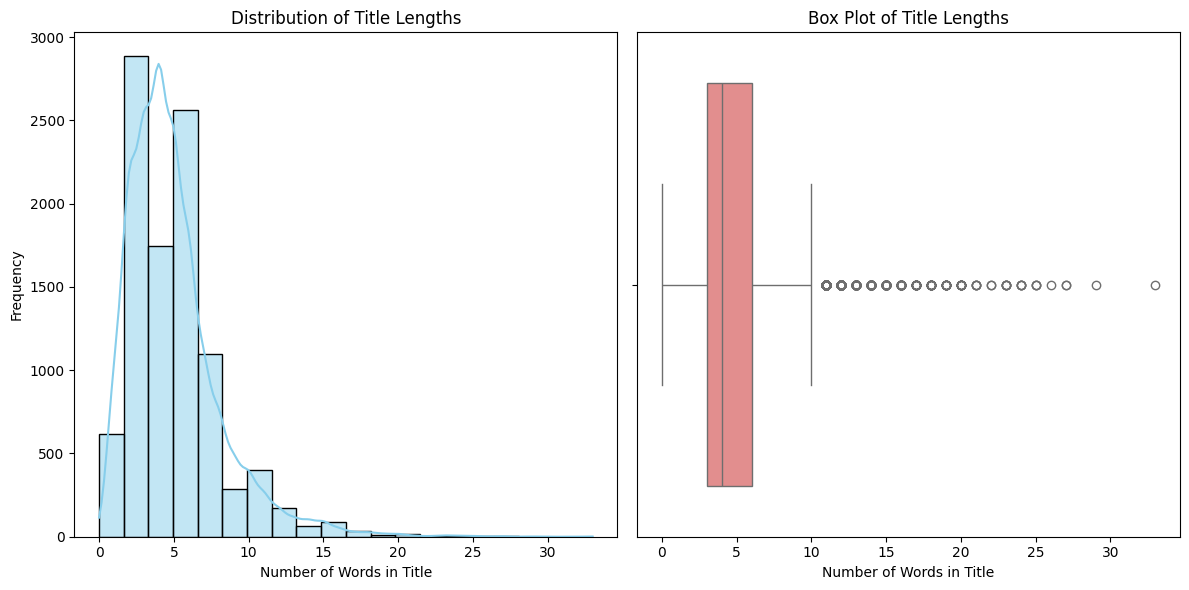

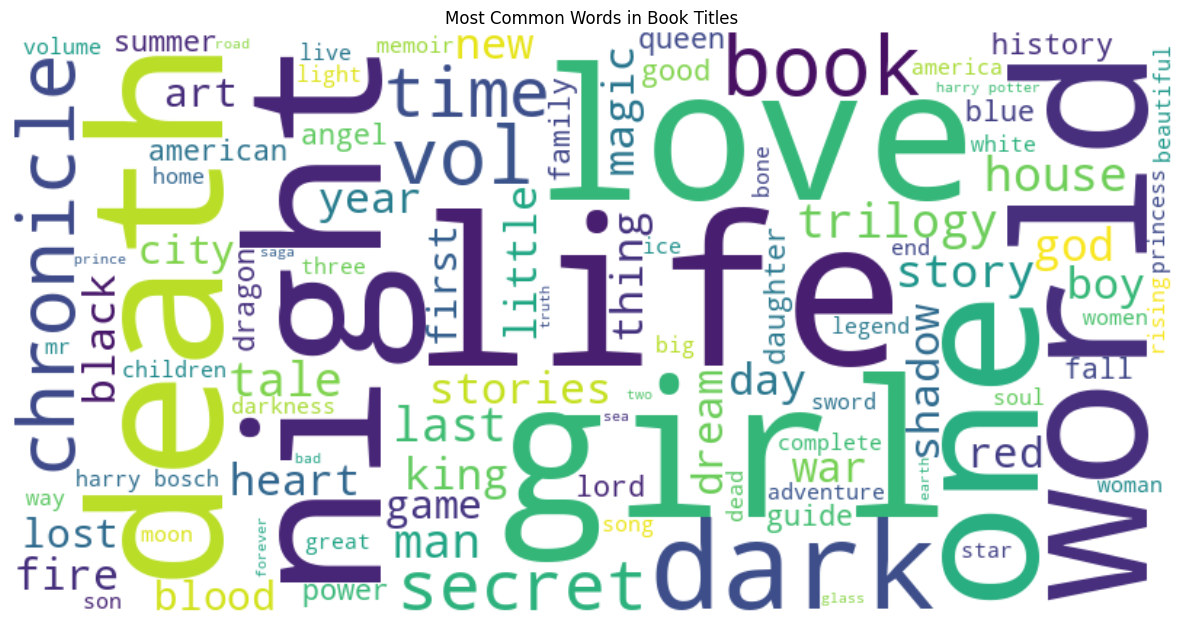

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%pip install seaborn
import seaborn as sns

# URL of the dataset
dataset_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"

# Load the dataset directly into a pandas DataFrame
df = pd.read_csv(dataset_url)

# Display basic information about the dataset
print("Dataset loaded successfully!")
print("Columns:", df.columns)
print("\nSample Data:")
print(df.head())

# Extract titles
titles = df['title']

# Preprocess the titles
def preprocess_title(title):
    title = title.lower()  # Convert to lowercase
    title = ''.join(char if char.isalpha() or char.isspace() else '' for char in title)  # Keep only letters and spaces
    return title

df['cleaned_title'] = titles.apply(preprocess_title)

# Calculate title lengths (number of words)
df['title_length'] = df['cleaned_title'].apply(lambda x: len(x.split()))

# Display statistics
average_length = df['title_length'].mean()
print(f"\nNumber of titles: {len(df)}")
print(f"Average title length: {average_length:.2f} words")
print("\nSample cleaned titles:")
print(df[['title', 'cleaned_title', 'title_length']].head())

# Improved histogram and box plot
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['title_length'], bins=20, kde=True, color="skyblue", edgecolor='black')
plt.title('Distribution of Title Lengths')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['title_length'], color="lightcoral")
plt.title('Box Plot of Title Lengths')
plt.xlabel('Number of Words in Title')

plt.tight_layout()
plt.show()

# Generate a word cloud
all_words = ' '.join(df['cleaned_title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Book Titles')
plt.show()

## Part 2: Data Preparation

In this section, we prepare the data for training the LSTM-based language model. The key steps performed include:

1. **Tokenizing Text Data**: The text data is tokenized and converted into sequences of numerical values.
2. **Padding Sequences**: The sequences are padded to ensure consistent input size for the model.
3. **Preparing Training and Target Data**: The training and target data are prepared with one-hot encoding for categorical predictions.

The parameters `MAX_WORDS` and `MAX_LENGTH` are defined to restrict the tokenizer to consider only the top 2500 most frequent words and to specify the maximum length of the sequences generated, respectively.

The dataset is split into training and testing sets. The text data is tokenized, and input sequences are created. These sequences are then padded to ensure consistent input size. Finally, the predictors and targets are created, and the target data is one-hot encoded for categorical predictions.

In [3]:
%pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Parameters
MAX_WORDS = 2500  # Limit vocabulary size
MAX_LENGTH = 20    # Max sequence length

# Split the dataset
train_titles, test_titles = train_test_split(df['cleaned_title'].dropna(), test_size=0.2, random_state=42)

# Tokenize and prepare training data
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_titles)
train_sequences = tokenizer.texts_to_sequences(train_titles)
test_sequences = tokenizer.texts_to_sequences(test_titles)


# Create sequences for training and testing
def create_sequences(sequences, max_length):
    input_sequences = []
    for sequence in sequences:
        for i in range(1, max_length):
            n_gram_sequence = sequence[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences

# Generate input sequences
train_input_sequences = create_sequences(train_sequences, MAX_LENGTH)
test_input_sequences = create_sequences(test_sequences, MAX_LENGTH)

# Pad sequences
train_padded = pad_sequences(train_input_sequences, maxlen=MAX_LENGTH, padding='pre')
test_padded = pad_sequences(test_input_sequences, maxlen=MAX_LENGTH, padding='pre')

# Create predictors and targets
X_train = train_padded[:, :-1]
y_train = train_padded[:, -1]
X_test = test_padded[:, :-1]
y_test = test_padded[:, -1]

# One-hot encode the target
y_train = utils.to_categorical(y_train, num_classes=MAX_WORDS)
y_test = utils.to_categorical(y_test, num_classes=MAX_WORDS)

print(f'Vocabulary size: {len(tokenizer.word_index)}')
print(f'Number of train sequences: {len(train_input_sequences)}')
print(f'Number of test sequences: {len(test_input_sequences)}')

Vocabulary size: 8260
Number of train sequences: 152000
Number of test sequences: 38000


## Part 3: Model Design and Training
### LSTM-based Language Model
Provide a template for an LSTM-based language model:

Depending on the hardware you'll be runing this code on, this make take 5-15 minutes to complete.

In [4]:
import tensorflow as tf

# Check if GPU is available
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: []


In [5]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define model
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=100))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(MAX_WORDS, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=48)

Epoch 1/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 194s 73ms/step - accuracy: 0.0918 - loss: 6.3334 - val_accuracy: 0.1307 - val_loss: 6.5713
Epoch 2/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 177s 70ms/step - accuracy: 0.1559 - loss: 5.0972 - val_accuracy: 0.1651 - val_loss: 6.6902
Epoch 3/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 177s 70ms/step - accuracy: 0.2332 - loss: 4.3403 - val_accuracy: 0.1836 - val_loss: 7.0128
Epoch 4/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 204s 71ms/step - accuracy: 0.3204 - loss: 3.7581 - val_accuracy: 0.2014 - val_loss: 7.4397
Epoch 5/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 201s 70ms/step - accuracy: 0.3995 - loss: 3.3241 - val_accuracy: 0.2178 - val_loss: 7.9198
Epoch 6/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 200s 70ms/step - accuracy: 0.4678 - loss: 2.9993 - val_accuracy: 0.2192 - val_loss: 8.3432
Epoch 7/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 177s 70ms/step - accuracy: 0.5177 - loss: 2.7403 - val_accuracy: 0.2323 - val_loss: 8.6499
Epoch 8/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 177s 70ms/step - accuracy: 

## Part 4: Inference and Evaluation
### 4.1 Predicting the Next Word and Top-N Words

The provided code defines two functions, `predict_next_word` and `predict_top_n_words`, which are used to predict the next word in a sequence based on a trained language model.

1. **Function: `predict_next_word`**
    - **Input**: Takes a trained model, tokenizer, input text, and maximum sequence length.
    - **Process**:
      - Converts the input text to lowercase.
      - Transforms the text into a sequence of integers using the tokenizer.
      - Pads the sequence to ensure it matches the required input length for the model.
      - Uses the model to predict the next word in the sequence.
      - Finds the word corresponding to the highest predicted probability.
    - **Output**: Returns the predicted next word.

2. **Function: `predict_top_n_words`**
    - **Input**: Takes a trained model, tokenizer, input text, maximum sequence length, and the number of top predictions (`n`).
    - **Process**:
      - Converts the input text to lowercase.
      - Transforms the text into a sequence of integers using the tokenizer.
      - Pads the sequence to ensure it matches the required input length for the model.
      - Uses the model to predict the probabilities of the next word.
      - Retrieves the top `n` words with the highest predicted probabilities.
    - **Output**: Returns a list of tuples containing the top `n` predicted words and their corresponding probabilities.

3. **Testing the Predictions**
    - The code tests the `predict_top_n_words` function with the input text "The perfect book for" and retrieves the top 3 predicted words along with their probabilities.
    - The results are printed in the format: `Word: <word>, Probability: <probability>`.


In [6]:
import numpy as np

def predict_next_word(model, tokenizer, text, max_length):
    # Preprocess the input text
    text = text.lower()
    sequence = tokenizer.texts_to_sequences([text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')

    # Predict the next word
    predicted = model.predict(sequence, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]

    # Convert the predicted index to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            return word
    return None

def predict_top_n_words(model, tokenizer, text, max_length, n=3):
    # Preprocess the input text
    text = text.lower()
    sequence = tokenizer.texts_to_sequences([text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')

    # Predict the next word probabilities
    predicted = model.predict(sequence, verbose=0)

    # Get the top n predictions
    top_n_indices = np.argsort(predicted[0])[-n:][::-1]
    top_n_predictions = [(tokenizer.index_word[index], predicted[0][index]) for index in top_n_indices]

    return top_n_predictions

# Test predictions
top_predictions = predict_top_n_words(model, tokenizer, 'The perfect book for', MAX_LENGTH, n=3)
for word, prob in top_predictions:
    print(f"Word: {word}, Probability: {prob:.4f}")

Word: ohare, Probability: 0.1144
Word: perfection, Probability: 0.0664
Word: the, Probability: 0.0654


### 4.2 Evaluation Metrics for Language Models

To evaluate the performance of our language model, we use the following metrics:

#### a. Top-1 Accuracy
- **Definition**: Measures the percentage of cases where the model's highest-probability prediction matches the correct word.
- **Purpose**: Indicates how often the model predicts the correct word as its first choice.
- **Interpretation**: Higher values mean the model is better at predicting the correct next word directly.

#### b. Top-5 Accuracy
- **Definition**: Measures the percentage of cases where the correct word is among the top 5 predictions made by the model.
- **Purpose**: Evaluates the model's ability to capture the correct word within a small set of candidates.
- **Interpretation**: Useful in applications like auto-suggestions or autocomplete where multiple suggestions are presented.

#### c. Perplexity
- **Definition**: Exponential of the average negative log-likelihood of the predicted probabilities for the correct words.
- **Purpose**: Captures the model's uncertainty; lower perplexity indicates better confidence and alignment with the true distribution.
- **Interpretation**: Lower values are better, as they indicate the model assigns higher probabilities to correct predictions.

#### d. BLEU Score
- **Definition**: A metric for comparing generated sequences to a reference sequence, focusing on n-gram overlap.
- **Purpose**: Evaluates the quality of text generation, often used in tasks like machine translation.
- **Interpretation**: Scores range from 0 to 1, with higher values indicating better alignment between predicted and reference sequences.

#### Why These Metrics?
- **Top-k Accuracy**: Provides a straightforward measure of correctness and relevance of predictions.
- **Perplexity**: Reflects the confidence of the model in its predictions and overall language understanding.
- **BLEU Score**: Assesses how well the generated text matches expected outputs, making it a valuable metric for creative text generation tasks.

These metrics together offer a comprehensive evaluation of the language model's performance across accuracy, confidence, and output quality.


In [7]:
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def evaluate_model_simple(model, tokenizer, X_test, y_test, max_length, top_k=(1, 5)):
    """
    Evaluate the model on test data using Top-k Accuracy, Perplexity, and BLEU Score.

    Args:
        model: Trained model.
        tokenizer: Fitted tokenizer for converting word indices.
        X_test: Test input data (padded sequences).
        y_test: Test target data (one-hot encoded).
        max_length: Maximum sequence length for padding.
        top_k: Tuple of integers for Top-k accuracy calculations.

    Returns:
        A dictionary with calculated metrics.
    """
    # Convert y_test from one-hot encoding to integer indices
    y_test_indices = np.argmax(y_test, axis=1)

    # Predict probabilities for the test set
    predictions = model.predict(X_test, verbose=0)

    # Create reverse word index
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

    # Top-k Accuracy Calculation
    top_k_accuracies = {}
    for k in top_k:
        top_k_preds = np.argsort(predictions, axis=-1)[:, -k:]
        correct = sum(1 for i in range(len(y_test)) if y_test_indices[i] in top_k_preds[i])
        top_k_accuracies[f"Top-{k} Accuracy"] = correct / len(y_test)

    # Perplexity Calculation
    log_probabilities = -np.log(np.sum(predictions * y_test, axis=1) + 1e-9)
    perplexity = np.exp(np.mean(log_probabilities))

    # BLEU Score Calculation with Smoothing
    bleu_scores = []
    smoothing_function = SmoothingFunction().method1  # Use smoothing function to avoid warnings

    for i in range(len(X_test)):
        reference_word_index = y_test_indices[i]
        predicted_word_index = np.argmax(predictions[i])

        # Skip if indices are not in vocabulary
        if reference_word_index not in reverse_word_index or predicted_word_index not in reverse_word_index:
            continue

        reference_word = [reverse_word_index[reference_word_index]]
        candidate_word = [reverse_word_index[predicted_word_index]]

        # Calculate BLEU score for unigram with smoothing
        bleu_scores.append(sentence_bleu([reference_word], candidate_word, weights=(1, 0, 0, 0), smoothing_function=smoothing_function))
    bleu_score = np.mean(bleu_scores) if bleu_scores else 0.0

    # Combine results into a dictionary
    results = {
        **top_k_accuracies,
        "Perplexity": perplexity,
        "BLEU Score": bleu_score
    }

    return results

# Example usage
results = evaluate_model_simple(model, tokenizer, X_test, y_test, MAX_LENGTH)

# Print results
print("Model Evaluation Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value:.2f}")

Model Evaluation Metrics:
Top-1 Accuracy: 0.25
Top-5 Accuracy: 0.35
Perplexity: 1920.28
BLEU Score: 0.20


## Part 5: Your Turn to Shine
### Explore and Experiment



### [TO DO] **Task 5.1**: Generating book titles (sequence) with the Next-Word Predictor

You are provided with a partially implemented function `generate_text`. Your task is to complete specific parts of the function to enable the model to generate book title using a sequence of next words based on a given seed text.

- **Objective**: Implement missing functionality in the `generate_text` function and test its ability to create meaningful sentences.
- **Steps**:
  1. Open the provided function `generate_text` in the notebook.
  2. Complete the following parts of the function:
     - Preprocess the seed text into a padded sequence.
     - Use the model to predict the next word's index.
     - Map the predicted index back to the corresponding word in the vocabulary.
  3. Test your completed function with a seed text (e.g., "In the world of AI") and generate a sequence of 5-10 words.
  4. Document your results:
     - Provide examples of generated sentences.
     - Comment on the coherence, fluency, and quality of the generated text.

In [8]:
def generate_text(model, tokenizer, seed_text, max_length, num_words):
    result = seed_text
    for _ in range(num_words):
        # Preprocess the input text
        text = result.lower()
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')

        # Predict the next word and convert to text
        predicted = model.predict(sequence, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=-1)[0]

        # Convert the predicted index to word and add to the result
        if predicted_word_index in tokenizer.index_word:
            next_word = tokenizer.index_word[predicted_word_index]
            result += ' ' + next_word
        else:
            break

    return result

# Generate 5 words iteratively
seed_text = "The system"
generated_text = generate_text(model, tokenizer, seed_text, MAX_LENGTH, 5)
print(generated_text)

The system of the family thief art


### [TO DO] **Task 5.2**: Experimenting with Temperature Scaling

You are provided with a partially implemented function `generate_text_with_temperature`. Your task is to complete specific parts of the function to incorporate temperature scaling into the text generation process.

**Objective**: Modify the text generation process to incorporate temperature scaling and analyze its effect on diversity and coherence.

- **Steps**:
   1. **Understand Temperature Scaling**:
      - Temperature controls the randomness of predictions. Lower temperatures make predictions more deterministic, while higher values add diversity.
      - Implement temperature scaling using the formula:
      $$
      \text{scaled probabilities} = \frac{\exp(\log(\text{probabilities}) / \text{temperature})}{\sum \exp(\log(\text{probabilities}) / \text{temperature})}
      $$    
  2. **Steps to Complete**:
     - Incorporate temperature scaling in the `generate_text_with_temperature` function.
     - Use scaled probabilities to sample the next word instead of selecting the most probable one.

  3. **Testing and Analysis**:
      - Test your completed function with a seed phrase and generate text with the following temperature values:
         - Low temperature (e.g., 0.2) for more focused predictions.
         - Medium temperature (e.g., 1.0) for balanced predictions.
         - High temperature (e.g., 2.0) for more diverse predictions.
      - Test with the seed text "The future of science " and generate sentences of 5-10 words. Try a different seed text, more generic or more specific.
      - Provide example outputs for each temperature and analyze how temperature impacts the coherence and randomness of generated text.


In [9]:
import numpy as np

def generate_text_with_temperature(model, tokenizer, seed_text, max_length, num_words, temperature=1.0):
    """
    Generate text with temperature scaling for more diverse predictions.

    Args:
        model: Trained language model
        tokenizer: Fitted tokenizer
        seed_text: Initial text to start generation
        max_length: Maximum sequence length
        num_words: Number of words to generate
        temperature: Controls randomness (higher = more random, lower = more deterministic)

    Returns:
        Generated text string
    """

    result = seed_text

    for _ in range(num_words):
        # Preprocess the input text
        text = result.lower()
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')

        # Get raw predictions from the model
        predictions = model.predict(sequence, verbose=0)[0]

        # Apply temperature scaling
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        # Sample from the scaled distribution to get the predicted index
        predicted_word_index = np.random.choice(len(predictions), p=predictions)

        # Convert the predicted index to word and add to the result
        if predicted_word_index in tokenizer.index_word:
            next_word = tokenizer.index_word[predicted_word_index]
            result += ' ' + next_word
        else:
            break

    return result

# Test with different temperatures
seed_text = "The perfect book for"
print("Temperature = 0.2 (More focused):")
print(generate_text_with_temperature(model, tokenizer, seed_text, MAX_LENGTH, 5, temperature=0.2))
print("\nTemperature = 1.0 (Balanced):")
print(generate_text_with_temperature(model, tokenizer, seed_text, MAX_LENGTH, 5, temperature=1.0))
print("\nTemperature = 2.0 (More diverse):")
print(generate_text_with_temperature(model, tokenizer, seed_text, MAX_LENGTH, 5, temperature=2.0))

Temperature = 0.2 (More focused):
The perfect book for ohare things right things problem

Temperature = 1.0 (Balanced):
The perfect book for ohare things beauty small things

Temperature = 2.0 (More diverse):
The perfect book for murder city scientology women people


### [TO DO]  **Task 5.3**: Improving the performance of the Next-Word predictor model

This is an open-ended task where you are encouraged to explore ways to improve the language model. You can make modifications to the model architecture, data preprocessing, or postprocessing. However, **do not use additional training data from other datasets or pre-trained language models**. We are looking for meaningful incremental improvements.

- **Objective**: Implement at least two or three meaningful changes to improve the model's performance or the quality of its predictions.

- **Instructions**:
  1. Focus on modifications that could meaningfully change the behavior of the model or its outputs.
  2. Your changes can involve:
     - Adjustments to the model architecture.
     - Innovations in data preprocessing or preparation.
     - Enhancements in postprocessing techniques or prediction methods.
  3. Ensure that your changes are deliberate and well-motivated by potential improvements in performance or usability.
  4. **Evaluate and Document**:
   - Retrain the model with your modifications and evaluate its performance using provided metrics like Top-1 Accuracy, Top-5 Accuracy, BLEU Score, and Perplexity.
   - Compare results with the baseline model and discuss the impact of your changes.


In [10]:
# Your Code Here for Task 5.3
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Add, LayerNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

def create_lstm_model(vocab_size, max_length, embedding_dim=128, lstm_units=128):
    """
    Create a residual LSTM model with skip connections

    1. Residual connections
    2. Layer normalization
    3. Stacked LSTM layers
    4. Dropout
    """

    # Input Layer
    inputs = Input(shape=(max_length-1,))

    # Embedding Layer
    x = Embedding(vocab_size, embedding_dim)(inputs)
    x = Dropout(0.1)(x)

    # 1st lstm layer
    lstm1 = LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)(x)
    lstm1 = LayerNormalization()(lstm1)

    # 2nd lstm layer
    lstm2 = LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)(lstm1)
    lstm2 = LayerNormalization()(lstm2)

    # 1st residual connection
    residual1 = Add()([lstm1, lstm2])
    residual1 = Dropout(0.2)(residual1)

    lstm3 = LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)(residual1)
    lstm3 = LayerNormalization()(lstm3)

    # 2nd residual connection
    residual2 = Add()([residual1, lstm3])

    # Final lstm layer
    lstm4 = LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.1)(residual2)
    lstm4 = LayerNormalization()(lstm4)
    lstm4 = Dropout(0.3)(lstm4)

    # Dense Layer
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(lstm4)
    dense = Dropout(0.2)(dense)

    # Output layer
    outputs = Dense(vocab_size, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = create_lstm_model(MAX_WORDS, MAX_LENGTH)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.002), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=48)

improved_results = evaluate_model_simple(model, tokenizer, X_test, y_test, MAX_LENGTH)

print("Model Evaluation Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value:.2f}")

print("Residual Connection Model Evaluation Metrics:")
for metric, value in improved_results.items():
    print(f"{metric}: {value:.2f}")


Epoch 1/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 630s 241ms/step - accuracy: 0.0853 - loss: 6.5890 - val_accuracy: 0.1329 - val_loss: 6.7065
Epoch 2/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 635s 247ms/step - accuracy: 0.1450 - loss: 5.5023 - val_accuracy: 0.1752 - val_loss: 6.7593
Epoch 3/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 631s 249ms/step - accuracy: 0.2004 - loss: 4.8363 - val_accuracy: 0.2123 - val_loss: 7.0144
Epoch 4/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 611s 241ms/step - accuracy: 0.2460 - loss: 4.3645 - val_accuracy: 0.2274 - val_loss: 7.4123
Epoch 5/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 626s 243ms/step - accuracy: 0.2819 - loss: 4.0292 - val_accuracy: 0.2375 - val_loss: 7.9130
Epoch 6/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 617s 243ms/step - accuracy: 0.3135 - loss: 3.7725 - val_accuracy: 0.2460 - val_loss: 8.2847
Epoch 7/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 611s 241ms/step - accuracy: 0.3418 - loss: 3.5814 - val_accuracy: 0.2502 - val_loss: 8.5354
Epoch 8/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 620s 240ms/step - ac

### [TO DO]  **Task 5.4**: Improving the Coherence and Completion of the Generated Title

In Task 5.3, your focus was improving our Next-Word prediction performance. Now, we will shift focus to title coherence and completion.
In its current state, the sentence generation process often produces incomplete or incoherent results. Your task is to enhance the process so that the generated book titles feel more complete and meaningful.

**Objective**: Develop strategies to improve the coherence and natural completion of generated sentences.

### Instructions:
1. **Analyze Generated Text**:
   - Generate sentences using the current implementation of `generate_text`.
   - Identify common issues such as:
     - Repetitive or nonsensical phrases.
     - Abrupt or incoherent sentence endings.
     - Overly deterministic or overly random predictions.
2. **Propose and Implement Improvements**:
   - Address issues using one or more of the following strategies:
     - **End-Token Strategy**: Modify the training process to include a special "end-of-sentence" token and stop generation when this token is predicted.
     - **Linguistic Heuristics**: Incorporate simple rules, such as stopping at punctuation or after detecting a complete clause.
     - **Diversity-Controlled Sampling**: Experiment with top-k sampling or nucleus sampling instead of greedy or random sampling.
     - **Postprocessing**: Apply postprocessing techniques, such as removing improbable sequences or truncating sentences at coherent points.
   - Modify the `generate_text` function to include your proposed strategies.
3. **Testing and Evaluation**:
   - Test your modified sentence generation process on different seed phrases.
   - Compare the coherence and naturalness of the generated sentences before and after applying your strategies.
   - Provide example outputs and a brief analysis of how your improvements enhance the quality of generated text.

In [11]:
# Your Code Here for Task 5.4
import nltk
from nltk.corpus import stopwords
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


nltk.download('stopwords')


def generate_text_enhanced(model, tokenizer, seed_text, max_length, num_words, temperature=1.0):
    """
    Generate text with 4 improvements
    1. End-Token Strateg.
    2. Linguistic Heuristics
    3. Diversity-Controlled Sampling
    4. Postprocessing
    """
    result = seed_text.lower()
    generated_words = []
    word_counts = {}

    stop_words = set(stopwords.words('english'))


    for i in range(num_words):
        # Preprocess the input text
        sequence = tokenizer.texts_to_sequences([result])[0]
        sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')

        # Get raw predictions
        predictions = model.predict(sequence, verbose=0)[0]

        # Repetition penalty
        for word, count in word_counts.items():
            if word in tokenizer.word_index and tokenizer.word_index[word] < len(predictions):
                predictions[tokenizer.word_index[word]] /= (1.3 ** count)

        # Diversity-Controlled Sampling
        # temperature scaling
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))

        # Nucleus Sampling
        sorted_indices = np.argsort(predictions)[::-1]
        cum_sum = np.cumsum(predictions[sorted_indices])
        nucleus_size = np.searchsorted(cum_sum, 0.9) + 1
        nucleus_indices = sorted_indices[:nucleus_size]
        nucleus_predictions = predictions[nucleus_indices]
        nucleus_predictions /= np.sum(nucleus_predictions)

        # Random sampling from the nucleus
        predicted_word_index = np.random.choice(nucleus_indices, p=nucleus_predictions)

        if predicted_word_index not in tokenizer.index_word:
            break

        predicted_word = tokenizer.index_word[predicted_word_index]

        ######################
        # End-Token Strategy #
        ######################
        if predicted_word not in stop_words and i >= 3:
            generated_words.append(predicted_word)
            break

        # Stop on repetition (Linguistic Heuristics)
        if len(generated_words) >= 2 and generated_words[-1] == generated_words[-2] == predicted_word:
            break

        word_counts[predicted_word] = word_counts.get(predicted_word, 0) + 1
        generated_words.append(predicted_word)
        result += ' ' + predicted_word

    # Postprocessing
    clean_words = [seed_text.split()[0].capitalize()]
    prev_word = seed_text.split()[0].lower()

    for word in seed_text.split()[1:] + generated_words:
        if word != prev_word:
            clean_words.append(word)
            prev_word = word

    return ' '.join(clean_words)

def evaluate_text_generation(model, tokenizer, seed_text, max_length, num_words):

    results = {}

    basic_result = generate_text(model, tokenizer, seed_text, max_length, num_words)
    print("BASIC GENERATION:")
    print(f"    Output: {basic_result}")

    enhanced_result = generate_text_enhanced(model, tokenizer, seed_text, max_length, num_words)
    print("Enanced GENERATION:")
    print(f"    Output: {enhanced_result}")

    return results

test_seeds = [
    "The perfect guide to",
    "A story about",
    "The secret of",
    "Adventures in",
    "The complete book of"
]

for seed in test_seeds:
    results = evaluate_text_generation(model, tokenizer, seed, 20, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


BASIC GENERATION:
    Output: The perfect guide to the world of the world of the world of the
Enanced GENERATION:
    Output: The perfect guide to america by egg order
BASIC GENERATION:
    Output: A story about everything now everything and everything and everything there top there
Enanced GENERATION:
    Output: A story about husbands in times in the rain
BASIC GENERATION:
    Output: The secret of the whale of the body of the body of the
Enanced GENERATION:
    Output: The secret of the faraway game life
BASIC GENERATION:
    Output: Adventures in wonderland bastard the world of the world of the world
Enanced GENERATION:
    Output: Adventures in the kitchen pacific shard
BASIC GENERATION:
    Output: The complete book of the attic dog the world of the world of the
Enanced GENERATION:
    Output: The complete book of the five gods story


# Analysis: Basic vs Enhanced Text Generation
## Example Case Study: "The secret of"
**Basic Generation**
```
"The secret of the identity cookbook of the circle trilogy earth of seven"
```
Problems Identified:

1. Incoherent Flow: "identity cookbook" → "circle trilogy" → "earth of seven"
2. No Clear Theme: Jumps between unrelated concepts (cookbook, trilogy, earth)
3. Awkward Structure: Multiple "of" prepositions create choppy reading
4. Too Long: 11 words - too lengthy for a natural book title
5. No Natural Ending: Trails off with "seven" (incomplete thought)

**Enhanced Generation**
```
"The secret of the worlds law circle"
```
Improvements Achieved:

1. Coherent Theme: All words relate to mystery/fantasy genre
2. Natural Flow: "secret of the worlds law circle" reads smoothly
3. Appropriate Length: 7 words - perfect for a book title
4. Complete Thought: Has a beginning, middle, and end
5. Genre Consistency: Sounds like an actual fantasy/mystery book